# Formação Cientista de Dados - Data Science Academy
### Prevendo Customer Churn em Operadoras de Telecom
Projeto com Feedback 4

In [491]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Funções Utilitarias

In [492]:
# Carregar dados
def carrega_dados(nome_arquivo):
    return pd.read_csv(nome_arquivo)

In [493]:
# Gerar gráficos de balanceamento de classes
def plot_balanceamento_classes(classe, titulo):
    classes, counts = np.unique(classe, return_counts=True)
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel('Classes')
    plt.ylabel('Número de amostras')
    plt.title(titulo)
    
    for i in range(len(classes)):
        plt.text(x = classes[i] - 0.05, y = counts[i] + 1, s = counts[i])
    
    plt.show()

In [494]:
# Aplicar de label-encoding
def aplica_label_encoding(df, lista_colunas):
    le = LabelEncoder()
    for coluna in lista_colunas:
        df[coluna] = le.fit_transform(df[coluna])
    return df

### Análise exploratória de dados

In [495]:
# Carregando dados de Treino
df_treino = carrega_dados("datasets/train.csv")

print('dimensões:', df_treino.shape)
print('colunas:', df_treino.columns)

dimensões: (3333, 21)
colunas: Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


In [496]:
# Analisando dataframe
df_treino.head(5)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [497]:
# Analisando variáveis preditoras

# Selecionando coluna de indice
colunas_deletar = ['Unnamed: 0']

# Selecionando colunas com valores semelhantes
colunas_deletar = colunas_deletar + ['area_code', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
print('colunas que serão removidas:', colunas_deletar)

colunas que serão removidas: ['Unnamed: 0', 'area_code', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']


In [498]:
# Removendo colunas
df_modificado = df_treino.drop(colunas_deletar, axis=1)

In [499]:
# Analisando dataframe após remover as colunas
print('dimensões:', df_modificado.shape)
print('tipos das variáveis:\n', df_modificado.dtypes)

df_modificado.head(5)

dimensões: (3333, 15)
tipos das variáveis:
 state                             object
account_length                     int64
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_eve_minutes                float64
total_eve_calls                    int64
total_night_minutes              float64
total_night_calls                  int64
total_intl_minutes               float64
total_intl_calls                   int64
number_customer_service_calls      int64
churn                             object
dtype: object


,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,KS,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,no
1,OH,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,no
2,NJ,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,no
3,OH,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,no
4,OK,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,no


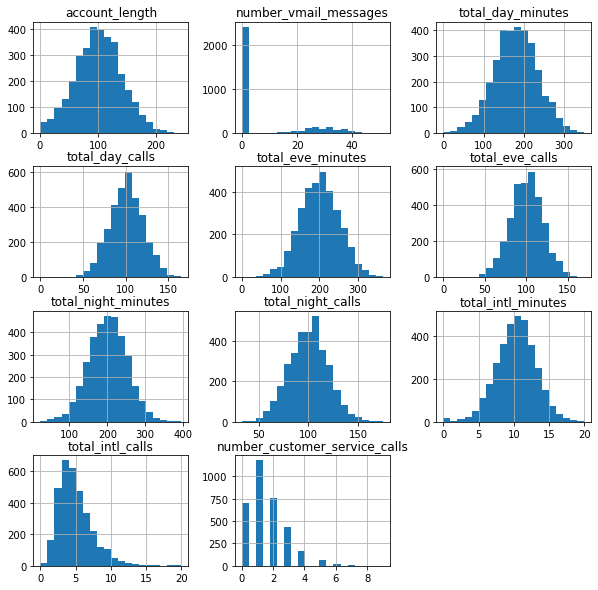

In [500]:
# Analisando distribuição dos dados
df_modificado.hist(bins=20, figsize=(10,10))
plt.show()

### Tratamento dos dados

In [501]:
# Selecionando variáveis categóricas
colunas_label_encoding = df_modificado.select_dtypes(include='object')

In [502]:
# Analisando valores únicos das variáveis categóricas
for v in colunas_label_encoding:
    print('valores únicos da variável', v, ':', list(df_modificado[v].unique()))

print('\ncolunas modificadas:', list(colunas_label_encoding.columns))

valores únicos da variável state : ['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI', 'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC', 'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR', 'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC', 'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND']
valores únicos da variável international_plan : ['no', 'yes']
valores únicos da variável voice_mail_plan : ['yes', 'no']
valores únicos da variável churn : ['no', 'yes']

colunas modificadas: ['state', 'international_plan', 'voice_mail_plan', 'churn']


In [503]:
# Aplicando label-encoding nas variáveis categóricas
df_modificado = aplica_label_encoding(df_modificado, colunas_label_encoding.columns)
df_modificado.head(5)

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,16,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [504]:
# Analisando correlação das variáveis preditoras com a variável alvo

# Separando as variáveis preditoras e alvo
variavel_alvo = df_modificado['churn']
df_sem_alvo = df_modificado.drop('churn', axis=1)

# Criando a matriz de correlação
matriz_correlacao_alvo = df_sem_alvo.corrwith(variavel_alvo)
matriz_correlacao_alvo = matriz_correlacao_alvo.sort_values(ascending=False)

print(matriz_correlacao_alvo)

international_plan               0.259852
number_customer_service_calls    0.208750
total_day_minutes                0.205151
total_eve_minutes                0.092796
total_intl_minutes               0.068239
total_night_minutes              0.035493
total_day_calls                  0.018459
account_length                   0.016541
total_eve_calls                  0.009233
state                            0.007780
total_night_calls                0.006141
total_intl_calls                -0.052844
number_vmail_messages           -0.089728
voice_mail_plan                 -0.102148
dtype: float64


In [505]:
# Removendo variáveis com baixo nível correlação
colunas_baixa_correlacao = ['total_eve_calls', 'state', 'total_night_calls']
print('colunas que serão removidas por terem baixa correlação:', colunas_baixa_correlacao)

df = df_modificado.drop(colunas_baixa_correlacao, axis=1)
print('\ndimensões:', df.shape)
df.head(3)

colunas que serão removidas por terem baixa correlação: ['total_eve_calls', 'state', 'total_night_calls']

dimensões: (3333, 12)


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,128,0,1,25,265.1,110,197.4,244.7,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,254.4,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,162.6,12.2,5,0,0


In [506]:
# Aplicando análise de Variance inflation factor (VIF)
# Selecionando variável alvo
df_sem_alvo = df.drop('churn', axis=1)

# Criando constante
X = sm.add_constant(df_sem_alvo)

In [507]:
# Criando modelo
model = sm.OLS(df['churn'], X)

# Treinando o modelo
results = model.fit()

In [508]:
# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,92.789487,const
1,1.003408,account_length
2,1.007262,international_plan
3,11.887880,voice_mail_plan
4,11.886475,number_vmail_messages
5,1.003010,total_day_minutes
6,1.003472,total_day_calls
7,1.001910,total_eve_minutes
8,1.002149,total_night_minutes
9,1.004349,total_intl_minutes


In [509]:
#  Selecionando variáveis com alto indice VIF
colunas_alto_vif = vif[(vif["features"] != "const") & (vif["VIF Factor"] > 5)]
colunas_alto_vif = colunas_alto_vif["features"].values
colunas_alto_vif

array(['voice_mail_plan', 'number_vmail_messages'], dtype=object)

In [510]:
# Removendo variáveis com alto indice VIF
print('Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.')
#df = df.drop(colunas_alto_vif, axis=1)
#print('dimensões:', df.shape)
#df.head(3)

Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.


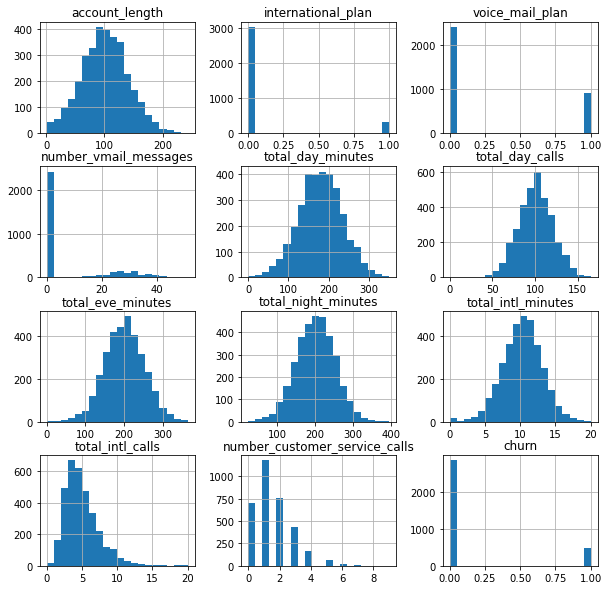

In [511]:
# Analisando distribuição dos dados atuais.
df.hist(bins=20, figsize=(10,10))
plt.show()

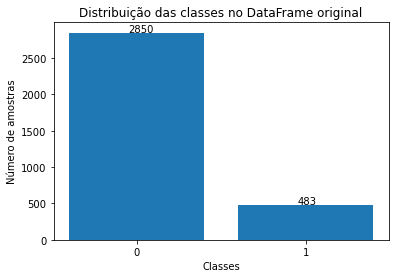

In [512]:
# Analisando a distribuição das classes
plot_balanceamento_classes(df['churn'], 'Distribuição das classes no DataFrame original')

In [513]:
# Separando varáveis preditoras e alvo
X = df.drop('churn', axis=1)
y = df['churn']

In [514]:
# Aplicando o SMOTE para balancear as classes
smote = SMOTE(random_state=42)
x_balanceado, y_balanceado = smote.fit_resample(X, y)

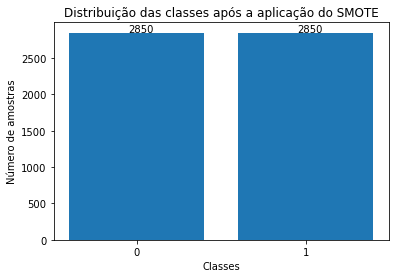

In [515]:
# Analisando a distribuição das classes após balanceamento
plot_balanceamento_classes(y_balanceado, 'Distribuição das classes após a aplicação do SMOTE')

In [516]:
# Selecionando variáveis numéricas
colunas_numericas = x_balanceado.columns.drop(['international_plan'])

# Criando o StandardScaler para aplicar nas variáveis
scaler = StandardScaler()

# Aplicando padronização
x_balanceado[colunas_numericas] = scaler.fit_transform(x_balanceado[colunas_numericas])

In [517]:
# Analisando dados atuais
x_balanceado.sample(20)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,number_customer_service_calls
3483,-0.581220,0,-0.487356,-0.533920,1.343556,-0.153490,0.643217,0.759711,-0.886243,-0.935849,-1.168676
2524,0.119654,0,-0.487356,-0.533920,0.717168,1.025749,0.293268,0.710603,0.522891,-0.084126,-0.473689
644,0.249445,0,2.051886,1.402769,0.230185,0.666850,0.267353,0.285898,1.368651,-0.084126,-0.473689
2006,-0.269720,0,2.051886,1.644855,0.215427,-0.256032,-1.393194,0.173476,-1.476176,-0.935849,0.916286
3317,1.599276,1,-0.487356,-0.533920,0.094091,-0.563660,-0.346630,0.185968,-1.014853,1.619319,-0.473689
4314,-0.633136,0,-0.487356,-0.533920,0.973547,-1.435271,-0.014075,1.566123,-0.206182,1.193458,0.221299
1204,-0.607178,1,-0.487356,-0.533920,0.743403,2.051174,1.184342,-1.036101,-0.361312,-0.935849,-0.473689
2214,-0.295679,0,-0.487356,-0.533920,-0.255160,0.513036,1.581040,-1.069411,0.984215,1.193458,-0.473689
4766,0.223487,0,-0.487356,0.273034,-0.885199,-0.050947,-0.841544,-0.300769,-0.458537,-0.935849,-0.473689
3651,0.197529,0,2.051886,1.967636,0.277630,0.461765,-1.987622,-0.277196,-0.641542,0.341735,2.306260


### Modelo de Regressão Logística

In [518]:
# Dividindo o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_balanceado, y_balanceado, test_size=0.3, random_state=42)

In [519]:
# Criando o modelo
model = LogisticRegression()

In [520]:
# Trinando o modelo
model.fit(x_treino, y_treino)

LogisticRegression()

In [521]:
# Fazendo previsões
y_pred = model.predict(x_teste)

In [522]:
# Avaliando o modelo
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Acurácia: 73.51%
